In [1]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


# Predict Sequence length : 12H

(4297, 12, 1) (4297, 1)
(12, 12, 1) (12, 1)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
68/68 [==============================] - 5s 26ms/step - loss: 0.0635 - val_loss: 4.0277e-05
Epoch 2/100
68/68 [==============================] - 2s 22ms/step - loss: 0.0555 - val_loss: 0.0049
Epoch 3/100
68/68 [==============================] - 2s 22ms/step - loss: 0.0557 - val_loss: 1.1018e-04
Epoch 4/100
68/68 [==============================] - 2s 22ms/step - loss: 0.0553 - val_loss: 0.0013
Epoch 5/100
68/68 [==============================] - 2s 23ms/step - loss: 0.0544 - val_loss: 6.1670e-05
Epoch 6/100
68/68 [==============================] - 2s 22ms/step - loss: 0.0532 - val_loss: 5.4269e-04
Epoch 7/100
68/68 [==============================] - 2s 22ms/step - loss: 0.0530 - val_loss: 0.0012
Epoch 8/100
68/68 [==============================] - 2s 23ms/step - loss: 0.0527 - val_loss: 1.4762e-05
Epoch 9/100
68/68 [==============================] - 2s 23ms/step - loss: 0.0528 - val_loss: 3.8472e-04
Epoch 10/100
68/68 [==============================] - 2s 23ms/step - loss: 0

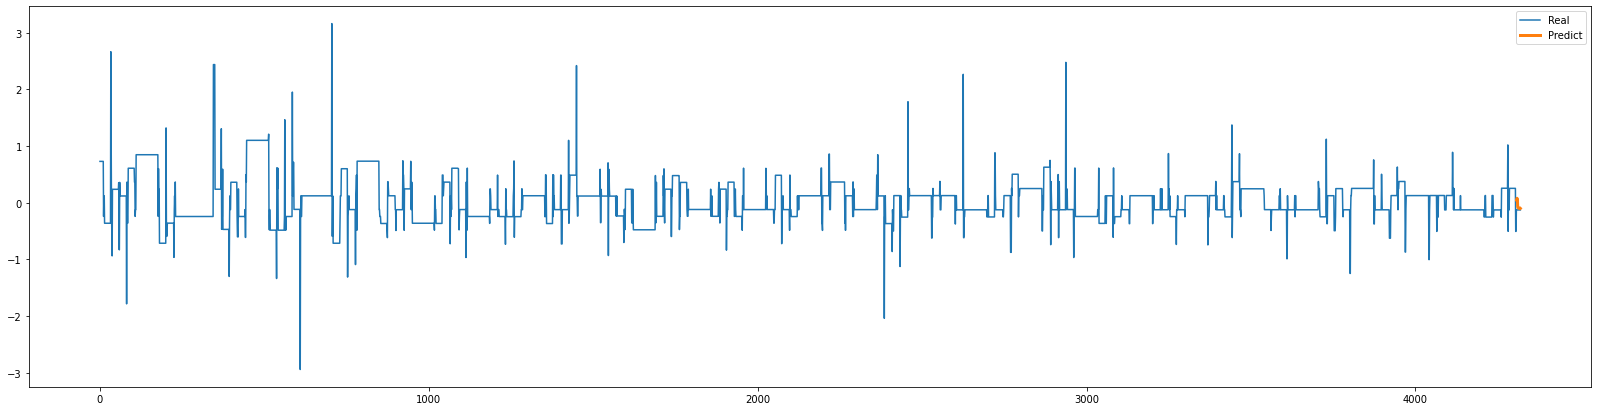

LSTM
----------------------------------------
MSE: 0.009893228571899473 |
MAE : 0.07257216429316853
LSTM 모델이 동작하는 시간 : 162.10768032073975



In [2]:
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import random
import os

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import * 
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

### LSTM 시간 측정 시작 ###

import time

time0 = time.time() 

### READ DATA ###

#일-월-년-시간 H 순으로 되어있네

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/삼성전자_6M_ST_Version1.csv', encoding='CP949')
df = df.dropna()
df = df.drop(df.columns[0], axis=1)

### CREATE GENERATOR FOR LSTM ###

sequence_length = 12

def gen_sequence(id_df, seq_length, seq_cols):
    
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

def gen_labels(id_df, seq_length, label):
    
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    
    return data_matrix[seq_length:num_elements, :]

def set_seed_TF2(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

X, Y = [], []
for sequence in gen_sequence(df, sequence_length, ['종가']):
    X.append(sequence)
    
for sequence in gen_labels(df, sequence_length, ['종가']):
    Y.append(sequence)
    
X = np.asarray(X)
Y = np.asarray(Y)

### TRAIN TEST SPLIT ###

train_dim = 12

X_train, X_test = X[:-train_dim], X[-train_dim:]
y_train, y_test = Y[:-train_dim], Y[-train_dim:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

### LSTM Model ###

inp = Input(shape=(12,1))

x = LSTM(64, activation='relu')(inp)
x = Dense(1)(x)
    
m = Model(inp, x)
m.compile(loss='mse', optimizer=Adam(lr=0.01))

### LSTM Model ###

history = m.fit(X_train, y_train, 
                epochs=100, 
                batch_size=64,
                validation_data=(X_test, y_test))

### VISUALIZE TEST PREDICTIONS ###

pred_LSTM_12 = m.predict(X_test).ravel()

plt.figure(figsize=(28,7))
plt.plot(range(0,4320), df['종가'][1:], label='Real')
plt.plot(range(4320-12,4320), pred_LSTM_12[-12:], linewidth=3, label='Predict')

plt.legend()
plt.show()

real = df['종가']

# LSTM 시간 측정 끝

TimeLSTM_12 = time.time() - time0

print('LSTM')
print('-' * 40)
print('MSE: {} |\nMAE : {}\nLSTM 모델이 동작하는 시간 : {}\n'.format(mean_squared_error(real[-12:], pred_LSTM_12[-12:]), mean_absolute_error(real[-12:],pred_LSTM_12[-12:]),TimeLSTM_12))

# Predict Sequence length : 24H

(4273, 24, 1) (4273, 1)
(24, 24, 1) (24, 1)
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


67/67 [==============================] - 4s 45ms/step - loss: 0.0616 - val_loss: 0.0329
Epoch 2/100
67/67 [==============================] - 3s 42ms/step - loss: 0.0563 - val_loss: 0.0307
Epoch 3/100
67/67 [==============================] - 3s 41ms/step - loss: 0.0550 - val_loss: 0.0276
Epoch 4/100
67/67 [==============================] - 3s 42ms/step - loss: 0.0555 - val_loss: 0.0323
Epoch 5/100
67/67 [==============================] - 3s 41ms/step - loss: 0.0539 - val_loss: 0.0287
Epoch 6/100
67/67 [==============================] - 3s 42ms/step - loss: 0.0532 - val_loss: 0.0338
Epoch 7/100
67/67 [==============================] - 3s 41ms/step - loss: 0.0526 - val_loss: 0.0292
Epoch 8/100
67/67 [==============================] - 3s 42ms/step - loss: 0.0525 - val_loss: 0.0300
Epoch 9/100
67/67 [==============================] - 3s 42ms/step - loss: 0.0532 - val_loss: 0.0322
Epoch 10/100
67/67 [==============================] - 3s 41ms/step - loss: 0.0521 - val_loss: 0.0306
Epoch 11/10

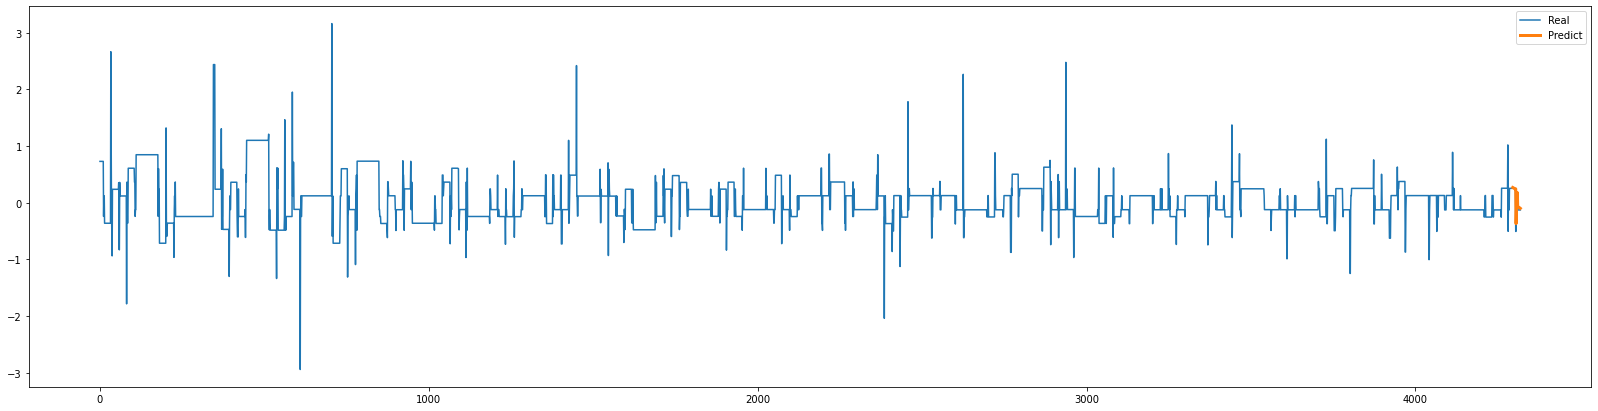

LSTM
----------------------------------------
MSE: 0.03217982816586845 |
MAE : 0.08658882185299904
LSTM 모델이 동작하는 시간 : 279.8186595439911



In [3]:
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import random
import os

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import * 
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

### LSTM 시간 측정 시작 ###

import time

time0 = time.time() 

### READ DATA ###

#일-월-년-시간 H 순으로 되어있네

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/삼성전자_6M_ST_Version1.csv', encoding='CP949')
df = df.dropna()
df = df.drop(df.columns[0], axis=1)

### CREATE GENERATOR FOR LSTM ###

sequence_length = 24

def gen_sequence(id_df, seq_length, seq_cols):
    
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

def gen_labels(id_df, seq_length, label):
    
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    
    return data_matrix[seq_length:num_elements, :]

def set_seed_TF2(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

X, Y = [], []
for sequence in gen_sequence(df, sequence_length, ['종가']):
    X.append(sequence)
    
for sequence in gen_labels(df, sequence_length, ['종가']):
    Y.append(sequence)
    
X = np.asarray(X)
Y = np.asarray(Y)

### TRAIN TEST SPLIT ###

train_dim = 24*1

X_train, X_test = X[:-train_dim], X[-train_dim:]
y_train, y_test = Y[:-train_dim], Y[-train_dim:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

### LSTM Model ###

inp = Input(shape=(24,1))

x = LSTM(64, activation='relu')(inp)
x = Dense(1)(x)
    
m = Model(inp, x)
m.compile(loss='mse', optimizer=Adam(lr=0.01))

### LSTM Model ###

history = m.fit(X_train, y_train, 
                epochs=100, 
                batch_size=64,
                validation_data=(X_test, y_test))

### VISUALIZE TEST PREDICTIONS ###

pred_LSTM_24 = m.predict(X_test).ravel()

plt.figure(figsize=(28,7))
plt.plot(range(0,4320), df['종가'][1:], label='Real')
plt.plot(range(4320-24*1,4320), pred_LSTM_24[-24*1:], linewidth=3, label='Predict')

plt.legend()
plt.show()

real = df['종가']

# LSTM 시간 측정 끝

TimeLSTM_24 = time.time() - time0

print('LSTM')
print('-' * 40)
print('MSE: {} |\nMAE : {}\nLSTM 모델이 동작하는 시간 : {}\n'.format(mean_squared_error(real[-24*1:], pred_LSTM_24[-24*1:]), mean_absolute_error(real[-24*1:],pred_LSTM_24[-24*1:]),TimeLSTM_24))

# Predict Sequence length : 48H

(4225, 48, 1) (4225, 1)
(48, 48, 1) (48, 1)
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


67/67 [==============================] - 7s 82ms/step - loss: 38722.2344 - val_loss: 0.0622
Epoch 2/100
67/67 [==============================] - 5s 79ms/step - loss: 0.0889 - val_loss: 0.0603
Epoch 3/100
67/67 [==============================] - 5s 79ms/step - loss: 0.0648 - val_loss: 0.0540
Epoch 4/100
67/67 [==============================] - 5s 81ms/step - loss: 0.0531 - val_loss: 0.0542
Epoch 5/100
67/67 [==============================] - 5s 81ms/step - loss: 0.0530 - val_loss: 0.0540
Epoch 6/100
67/67 [==============================] - 5s 79ms/step - loss: 0.0520 - val_loss: 0.0543
Epoch 7/100
67/67 [==============================] - 5s 80ms/step - loss: 0.0517 - val_loss: 0.0564
Epoch 8/100
67/67 [==============================] - 5s 81ms/step - loss: 0.0513 - val_loss: 0.0538
Epoch 9/100
67/67 [==============================] - 5s 80ms/step - loss: 0.0504 - val_loss: 0.0543
Epoch 10/100
67/67 [==============================] - 5s 78ms/step - loss: 0.0506 - val_loss: 0.0548
Epoch 1

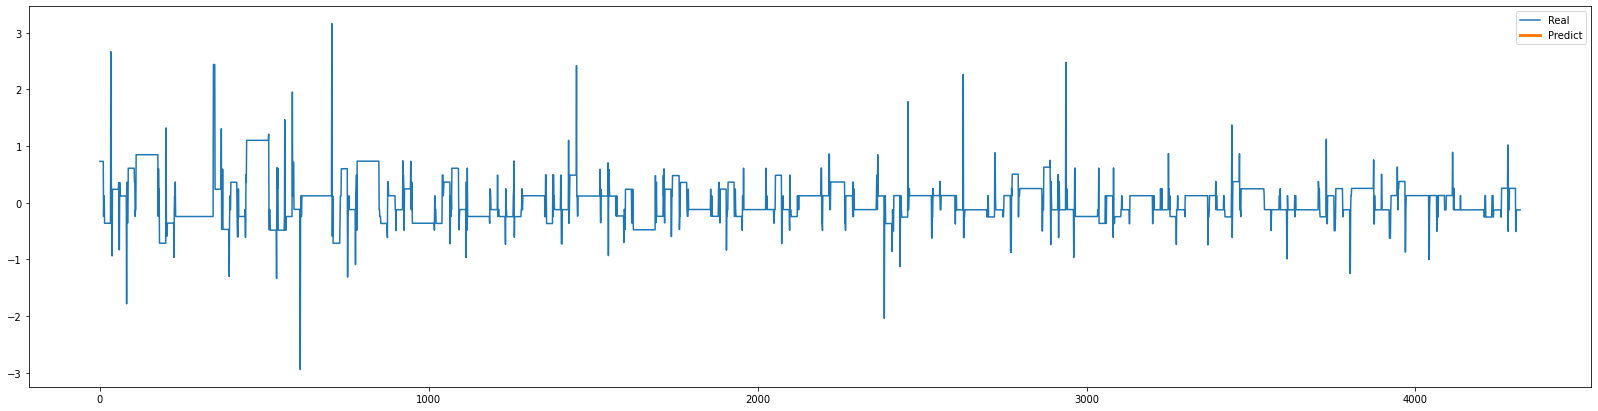

LSTM
----------------------------------------


ValueError: ignored

In [4]:
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import random
import os

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import * 
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

### LSTM 시간 측정 시작 ###

import time

time0 = time.time() 

### READ DATA ###

#일-월-년-시간 H 순으로 되어있네

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/삼성전자_6M_ST_Version1.csv', encoding='CP949')
df = df.dropna()
df = df.drop(df.columns[0], axis=1)

### CREATE GENERATOR FOR LSTM ###

sequence_length = 24*2

def gen_sequence(id_df, seq_length, seq_cols):
    
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

def gen_labels(id_df, seq_length, label):
    
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    
    return data_matrix[seq_length:num_elements, :]

def set_seed_TF2(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

X, Y = [], []
for sequence in gen_sequence(df, sequence_length, ['종가']):
    X.append(sequence)
    
for sequence in gen_labels(df, sequence_length, ['종가']):
    Y.append(sequence)
    
X = np.asarray(X)
Y = np.asarray(Y)

### TRAIN TEST SPLIT ###

train_dim = 24*2

X_train, X_test = X[:-train_dim], X[-train_dim:]
y_train, y_test = Y[:-train_dim], Y[-train_dim:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

### LSTM Model ###

inp = Input(shape=(24*2,1))

x = LSTM(64, activation='relu')(inp)
x = Dense(1)(x)
    
m = Model(inp, x)
m.compile(loss='mse', optimizer=Adam(lr=0.01))

### LSTM Model ###

history = m.fit(X_train, y_train, 
                epochs=100, 
                batch_size=64,
                validation_data=(X_test, y_test))

### VISUALIZE TEST PREDICTIONS ###

pred_LSTM_48 = m.predict(X_test).ravel()

plt.figure(figsize=(28,7))
plt.plot(range(0,4320), df['종가'][1:], label='Real')
plt.plot(range(4320-24*2,4320), pred_LSTM_48[-24*2:], linewidth=3, label='Predict')

plt.legend()
plt.show()

real = df['종가']

# LSTM 시간 측정 끝

TimeLSTM_48 = time.time() - time0

print('LSTM')
print('-' * 40)
print('MSE: {} |\nMAE : {}\nLSTM 모델이 동작하는 시간 : {}\n'.format(mean_squared_error(real[-24*2:], pred_LSTM_48[-24*2:]), mean_absolute_error(real[-24*2:],pred_LSTM_48[-24*2:]),TimeLSTM_48))

# Predict Sequence length : 96H

(4129, 96, 1) (4129, 1)
(96, 96, 1) (96, 1)
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


65/65 [==============================] - 12s 161ms/step - loss: 1326375552.0000 - val_loss: 0.0548
Epoch 2/100
65/65 [==============================] - 10s 158ms/step - loss: 0.0788 - val_loss: 0.0404
Epoch 3/100
65/65 [==============================] - 10s 159ms/step - loss: 0.0615 - val_loss: 0.0395
Epoch 4/100
65/65 [==============================] - 10s 158ms/step - loss: 0.0591 - val_loss: 0.0388
Epoch 5/100
65/65 [==============================] - 10s 157ms/step - loss: 0.0571 - val_loss: 0.0372
Epoch 6/100
65/65 [==============================] - 10s 158ms/step - loss: 0.0548 - val_loss: 0.0352
Epoch 7/100
65/65 [==============================] - 10s 157ms/step - loss: 0.0548 - val_loss: 0.0348
Epoch 8/100
65/65 [==============================] - 10s 158ms/step - loss: 0.0531 - val_loss: 0.0341
Epoch 9/100
65/65 [==============================] - 10s 160ms/step - loss: 0.0523 - val_loss: 0.0342
Epoch 10/100
65/65 [==============================] - 10s 159ms/step - loss: 0.0515 -

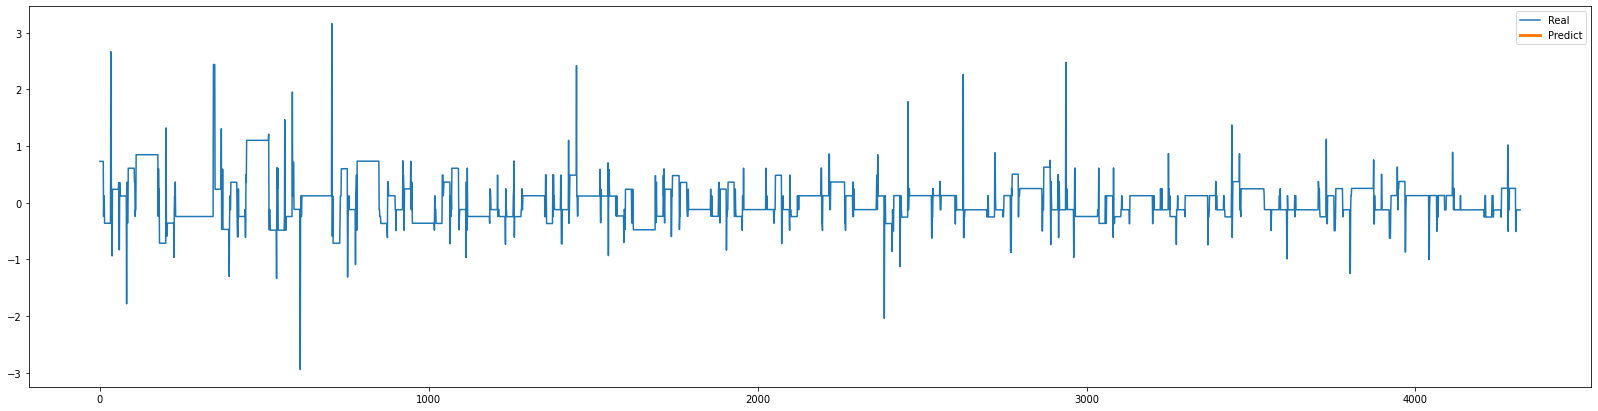

LSTM
----------------------------------------


ValueError: ignored

In [5]:
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import random
import os

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import * 
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

### LSTM 시간 측정 시작 ###

import time

time0 = time.time() 

### READ DATA ###

#일-월-년-시간 H 순으로 되어있네

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/삼성전자_6M_ST_Version1.csv', encoding='CP949')
df = df.dropna()
df = df.drop(df.columns[0], axis=1)

### CREATE GENERATOR FOR LSTM ###

sequence_length = 24*4

def gen_sequence(id_df, seq_length, seq_cols):
    
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

def gen_labels(id_df, seq_length, label):
    
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    
    return data_matrix[seq_length:num_elements, :]

def set_seed_TF2(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

X, Y = [], []
for sequence in gen_sequence(df, sequence_length, ['종가']):
    X.append(sequence)
    
for sequence in gen_labels(df, sequence_length, ['종가']):
    Y.append(sequence)
    
X = np.asarray(X)
Y = np.asarray(Y)

### TRAIN TEST SPLIT ###

train_dim = 24*4

X_train, X_test = X[:-train_dim], X[-train_dim:]
y_train, y_test = Y[:-train_dim], Y[-train_dim:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

### LSTM Model ###

inp = Input(shape=(24*4,1))

x = LSTM(64, activation='relu')(inp)
x = Dense(1)(x)
    
m = Model(inp, x)
m.compile(loss='mse', optimizer=Adam(lr=0.01))

### LSTM Model ###

history = m.fit(X_train, y_train, 
                epochs=100, 
                batch_size=64,
                validation_data=(X_test, y_test))

### VISUALIZE TEST PREDICTIONS ###

pred_LSTM_96 = m.predict(X_test).ravel()

plt.figure(figsize=(28,7))
plt.plot(range(0,4320), df['종가'][1:], label='Real')
plt.plot(range(4320-24*4,4320), pred_LSTM_96[-24*4:], linewidth=3, label='Predict')

plt.legend()
plt.show()

real = df['종가']

# LSTM 시간 측정 끝

TimeLSTM_96 = time.time() - time0

print('LSTM')
print('-' * 40)
print('MSE: {} |\nMAE : {}\nLSTM 모델이 동작하는 시간 : {}\n'.format(mean_squared_error(real[-24*4:], pred_LSTM_96[-24*4:]), mean_absolute_error(real[-24*4:],pred_LSTM_96[-24*4:]),TimeLSTM_96))

# Predict Sequence length : 192H

In [6]:
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import random
import os

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import * 
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

### LSTM 시간 측정 시작 ###

import time

time0 = time.time() 

### READ DATA ###

#일-월-년-시간 H 순으로 되어있네

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/삼성전자_6M_ST_Version1.csv', encoding='CP949')
df = df.dropna()
df = df.drop(df.columns[0], axis=1)

### CREATE GENERATOR FOR LSTM ###

sequence_length = 24*8

def gen_sequence(id_df, seq_length, seq_cols):
    
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

def gen_labels(id_df, seq_length, label):
    
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    
    return data_matrix[seq_length:num_elements, :]

def set_seed_TF2(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

X, Y = [], []
for sequence in gen_sequence(df, sequence_length, ['종가']):
    X.append(sequence)
    
for sequence in gen_labels(df, sequence_length, ['종가']):
    Y.append(sequence)
    
X = np.asarray(X)
Y = np.asarray(Y)

### TRAIN TEST SPLIT ###

train_dim = 24*8

X_train, X_test = X[:-train_dim], X[-train_dim:]
y_train, y_test = Y[:-train_dim], Y[-train_dim:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

### LSTM Model ###

inp = Input(shape=(24*8,1))

x = LSTM(64, activation='relu')(inp)
x = Dense(1)(x)
    
m = Model(inp, x)
m.compile(loss='mse', optimizer=Adam(lr=0.01))

### LSTM Model ###

history = m.fit(X_train, y_train, 
                epochs=100, 
                batch_size=64,
                validation_data=(X_test, y_test))

### VISUALIZE TEST PREDICTIONS ###

pred_LSTM_192 = m.predict(X_test).ravel()

plt.figure(figsize=(28,7))
plt.plot(range(0,4320), df['종가'][1:], label='Real')
plt.plot(range(4320-24*8,4320), pred_LSTM_96[-24*8:], linewidth=3, label='Predict')

plt.legend()
plt.show()

real = df['종가']

# LSTM 시간 측정 끝

TimeLSTM_192 = time.time() - time0

print('LSTM')
print('-' * 40)
print('MSE: {} |\nMAE : {}\nLSTM 모델이 동작하는 시간 : {}\n'.format(mean_squared_error(real[-24*8:], pred_LSTM_192[-24*8:]), mean_absolute_error(real[-24*8:],pred_LSTM_192[-24*8:]),TimeLSTM_192))

(3937, 192, 1) (3937, 1)
(192, 192, 1) (192, 1)
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


62/62 [==============================] - 21s 315ms/step - loss: nan - val_loss: nan
Epoch 2/100
62/62 [==============================] - 19s 308ms/step - loss: nan - val_loss: nan
Epoch 3/100
62/62 [==============================] - 19s 308ms/step - loss: nan - val_loss: nan
Epoch 4/100
24/62 [==========>...................] - ETA: 11s - loss: nan

KeyboardInterrupt: ignored

# Predict Sequence length : 336H

In [7]:
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import random
import os

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import * 
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

### LSTM 시간 측정 시작 ###

import time

time0 = time.time() 

### READ DATA ###

#일-월-년-시간 H 순으로 되어있네

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/삼성전자_6M_ST_Version1.csv', encoding='CP949')
df = df.dropna()
df = df.drop(df.columns[0], axis=1)

### CREATE GENERATOR FOR LSTM ###

sequence_length = 24*14

def gen_sequence(id_df, seq_length, seq_cols):
    
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

def gen_labels(id_df, seq_length, label):
    
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    
    return data_matrix[seq_length:num_elements, :]

def set_seed_TF2(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

X, Y = [], []
for sequence in gen_sequence(df, sequence_length, ['종가']):
    X.append(sequence)
    
for sequence in gen_labels(df, sequence_length, ['종가']):
    Y.append(sequence)
    
X = np.asarray(X)
Y = np.asarray(Y)

### TRAIN TEST SPLIT ###

train_dim = 24*14

X_train, X_test = X[:-train_dim], X[-train_dim:]
y_train, y_test = Y[:-train_dim], Y[-train_dim:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

### LSTM Model ###

inp = Input(shape=(24*14,1))

x = LSTM(64, activation='relu')(inp)
x = Dense(1)(x)
    
m = Model(inp, x)
m.compile(loss='mse', optimizer=Adam(lr=0.01))

### LSTM Model ###

history = m.fit(X_train, y_train, 
                epochs=100, 
                batch_size=64,
                validation_data=(X_test, y_test))

### VISUALIZE TEST PREDICTIONS ###

pred_LSTM_336 = m.predict(X_test).ravel()

plt.figure(figsize=(28,7))
plt.plot(range(0,4320), df['종가'][1:], label='Real')
plt.plot(range(4320-24*14,4320), pred_LSTM_336[-24*14:], linewidth=3, label='Predict')

plt.legend()
plt.show()

real = df['종가']

# LSTM 시간 측정 끝

TimeLSTM_336 = time.time() - time0

print('LSTM')
print('-' * 40)
print('MSE: {} |\nMAE : {}\nLSTM 모델이 동작하는 시간 : {}\n'.format(mean_squared_error(real[-24*14:], pred_LSTM_336[-24*14:]), mean_absolute_error(real[-24*14:],pred_LSTM_336[-24*14:]),TimeLSTM_336))

(3649, 336, 1) (3649, 1)
(336, 336, 1) (336, 1)
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


58/58 [==============================] - 33s 546ms/step - loss: 0.0607 - val_loss: 0.0223
Epoch 2/100
58/58 [==============================] - 31s 538ms/step - loss: nan - val_loss: nan
Epoch 3/100
58/58 [==============================] - 31s 540ms/step - loss: nan - val_loss: nan
Epoch 4/100
58/58 [==============================] - 31s 540ms/step - loss: nan - val_loss: nan
Epoch 5/100
15/58 [======>.......................] - ETA: 23s - loss: nan

KeyboardInterrupt: ignored

# Predict Sequence length : 480H

In [8]:
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import random
import os

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import * 
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

### LSTM 시간 측정 시작 ###

import time

time0 = time.time() 

### READ DATA ###

#일-월-년-시간 H 순으로 되어있네

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/삼성전자_6M_ST_Version1.csv', encoding='CP949')
df = df.dropna()
df = df.drop(df.columns[0], axis=1)

### CREATE GENERATOR FOR LSTM ###

sequence_length = 24*20

def gen_sequence(id_df, seq_length, seq_cols):
    
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

def gen_labels(id_df, seq_length, label):
    
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    
    return data_matrix[seq_length:num_elements, :]

def set_seed_TF2(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

X, Y = [], []
for sequence in gen_sequence(df, sequence_length, ['종가']):
    X.append(sequence)
    
for sequence in gen_labels(df, sequence_length, ['종가']):
    Y.append(sequence)
    
X = np.asarray(X)
Y = np.asarray(Y)

### TRAIN TEST SPLIT ###

train_dim = 24*20

X_train, X_test = X[:-train_dim], X[-train_dim:]
y_train, y_test = Y[:-train_dim], Y[-train_dim:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

### LSTM Model ###

inp = Input(shape=(24*20,1))

x = LSTM(64, activation='relu')(inp)
x = Dense(1)(x)
    
m = Model(inp, x)
m.compile(loss='mse', optimizer=Adam(lr=0.01))

### LSTM Model ###

history = m.fit(X_train, y_train, 
                epochs=100, 
                batch_size=64,
                validation_data=(X_test, y_test))

### VISUALIZE TEST PREDICTIONS ###

pred_LSTM_480 = m.predict(X_test).ravel()

plt.figure(figsize=(28,7))
plt.plot(range(0,4320), df['종가'][1:], label='Real')
plt.plot(range(4320-24*20,4320), pred_LSTM_336[-24*20:], linewidth=3, label='Predict')

plt.legend()
plt.show()

real = df['종가']

# LSTM 시간 측정 끝

TimeLSTM_480 = time.time() - time0

print('LSTM')
print('-' * 40)
print('MSE: {} |\nMAE : {}\nLSTM 모델이 동작하는 시간 : {}\n'.format(mean_squared_error(real[-24*20:], pred_LSTM_480[-24*20:]), mean_absolute_error(real[-24*20:],pred_LSTM_480[-24*20:]),TimeLSTM_480))

(3361, 480, 1) (3361, 1)
(480, 480, 1) (480, 1)
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


53/53 [==============================] - 42s 768ms/step - loss: nan - val_loss: nan
Epoch 2/100
53/53 [==============================] - 40s 760ms/step - loss: nan - val_loss: nan
Epoch 3/100
 6/53 [==>...........................] - ETA: 35s - loss: nan

KeyboardInterrupt: ignored

# Predict Sequence length : 720H

In [9]:
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import random
import os

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import * 
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

### LSTM 시간 측정 시작 ###

import time

time0 = time.time() 

### READ DATA ###

#일-월-년-시간 H 순으로 되어있네

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/삼성전자_6M_ST_Version1.csv', encoding='CP949')
df = df.dropna()
df = df.drop(df.columns[0], axis=1)

### CREATE GENERATOR FOR LSTM ###

sequence_length = 24*30

def gen_sequence(id_df, seq_length, seq_cols):
    
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

def gen_labels(id_df, seq_length, label):
    
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    
    return data_matrix[seq_length:num_elements, :]

def set_seed_TF2(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

X, Y = [], []
for sequence in gen_sequence(df, sequence_length, ['종가']):
    X.append(sequence)
    
for sequence in gen_labels(df, sequence_length, ['종가']):
    Y.append(sequence)
    
X = np.asarray(X)
Y = np.asarray(Y)

### TRAIN TEST SPLIT ###

train_dim = 24*30

X_train, X_test = X[:-train_dim], X[-train_dim:]
y_train, y_test = Y[:-train_dim], Y[-train_dim:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

### LSTM Model ###

inp = Input(shape=(24*30,1))

x = LSTM(64, activation='relu')(inp)
x = Dense(1)(x)
    
m = Model(inp, x)
m.compile(loss='mse', optimizer=Adam(lr=0.01))

### LSTM Model ###

history = m.fit(X_train, y_train, 
                epochs=100, 
                batch_size=64,
                validation_data=(X_test, y_test))

### VISUALIZE TEST PREDICTIONS ###

pred_LSTM_720 = m.predict(X_test).ravel()

plt.figure(figsize=(28,7))
plt.plot(range(0,4320), df['종가'][1:], label='Real')
plt.plot(range(4320-24*30,4320), pred_LSTM_720[-24*30:], linewidth=3, label='Predict')

plt.legend()
plt.show()

real = df['종가']

# LSTM 시간 측정 끝

TimeLSTM_720 = time.time() - time0

print('LSTM')
print('-' * 40)
print('MSE: {} |\nMAE : {}\nLSTM 모델이 동작하는 시간 : {}\n'.format(mean_squared_error(real[-24*30:], pred_LSTM_720[-24*30:]), mean_absolute_error(real[-24*30:],pred_LSTM_720[-24*30:]),TimeLSTM_720))

(2881, 720, 1) (2881, 1)
(720, 720, 1) (720, 1)
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


46/46 [==============================] - 55s 1s/step - loss: nan - val_loss: nan
Epoch 2/100
46/46 [==============================] - 53s 1s/step - loss: nan - val_loss: nan
Epoch 3/100
46/46 [==============================] - 53s 1s/step - loss: nan - val_loss: nan
Epoch 4/100
39/46 [========================>.....] - ETA: 7s - loss: nan

KeyboardInterrupt: ignored

In [11]:
print('LSTM_12')
print('MSE: {} |\nMAE : {}\nLSTM 모델이 동작하는 시간 : {}\n'.format(mean_squared_error(real[-12:], pred_LSTM_12[-12:]), mean_absolute_error(real[-12:],pred_LSTM_12[-12:]),TimeLSTM_12))
print('-' * 40)
print('LSTM_24')
print('MSE: {} |\nMAE : {}\nLSTM 모델이 동작하는 시간 : {}\n'.format(mean_squared_error(real[-24*1:], pred_LSTM_24[-24*1:]), mean_absolute_error(real[-24*1:],pred_LSTM_24[-24*1:]),TimeLSTM_24))
print('-' * 40)
print('LSTM')
print('MSE: {} |\nMAE : {}\nLSTM 모델이 동작하는 시간 : {}\n'.format(mean_squared_error(real[-24*2:], pred_LSTM_48[-24*2:]), mean_absolute_error(real[-24*2:],pred_LSTM_48[-24*2:]),TimeLSTM_48))

LSTM_12
MSE: 0.009893228571899473 |
MAE : 0.07257216429316853
LSTM 모델이 동작하는 시간 : 162.10768032073975

----------------------------------------
LSTM_24
MSE: 0.03217982816586845 |
MAE : 0.08658882185299904
LSTM 모델이 동작하는 시간 : 279.8186595439911

----------------------------------------
LSTM


ValueError: ignored